Michael Haugan <br>
MSDS 422 - Winter 2019 <br>
Assignment 7: Convolutional Neural Networks <br>

# overview
This assignment follows the same structure as Assignment 6. We will employ at least a 2x2 completely crossed experimental design. We will again use a simple training-and-test regimen. The factors in the design may include numbers of layers and/or nodes within layers, types of layers (convolutional or pooling), and/or other hyperparameters. You will utilize convolutional neural networks (CNNs) within Python TensorFlow. 

This week, you will compete in the Dogs vs. Cats Kaggle.com competition, https://www.kaggle.com/c/dogs-vs-cats .  (Links to an external site.)Links to an external site.Specifically, you will build models using the training set to forecast the test set. The images are in .jpg format, so you will need to research how to handle that.  You are required to submit no fewer than four models for evaluation by Kaggle.com, and you must provide your Kaggle.com scores and user ID for validation. 

# objective
Assume that we are providing advice to a website provider who is looking for tools to automatically label images provided by end users. As we look across the factors in the study, making recommendations to management about image classification, we are most concerned about achieving the highest possible accuracy in image classification. That is, we should be willing to sacrifice training time for model accuracy. What type of machine learning model works best? If it is a convolutional neural network, what type of network should we use? Part of this recommendation may concern information about the initial images themselves (input data for the classification task). What types of images work best?

# setup

In [59]:
# import packages and set parameters
SET_FIT_INTERCEPT = True
RAND = 23
import numpy as np
from scipy.stats import kurtosis
from scipy.stats import skew
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model 
from time import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, make_scorer  
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from glob import glob
import tensorflow as tf
from random import shuffle
import cv2
import os
import re

import tflearn
from tflearn.data_utils import shuffle, to_categorical
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation
from tflearn.metrics import Accuracy

#suppress tf.logging
import logging
logging.getLogger('tensorflow').disabled = True

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# eda

In [2]:
width = 64
height = 64
TRAIN_DIR = '/Users/michael/msds_420_assignment7/train'
TEST_DIR = '/Users/michael/msds_420_assignment7/test1'
train_images_list = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
test_images_list = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

In [34]:
# using arrays already built within the starter code files
# gray scale
cats_1000_64_64_1 = np.load('cats_1000_64_64_1.npy')
dogs_1000_64_64_1 = np.load('dogs_1000_64_64_1.npy')

# color
cats_1000_64_64_3 = np.load('cats_1000_64_64_3.npy')
dogs_1000_64_64_3 = np.load('dogs_1000_64_64_3.npy')

In [4]:
def show_grayscale_image(image):
    plt.imshow(image, cmap = 'gray') 
    plt.axis('off')
    plt.show()

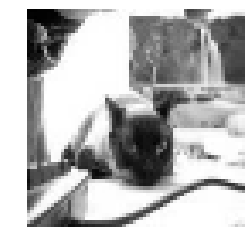

In [5]:
# view random grayscale image
show_grayscale_image(cats_1000_64_64_1[5,:,:,0])

In [6]:
def show_color_image(image):
    plt.imshow(image) 
    plt.axis('off')
    plt.show()   

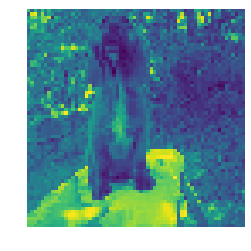

In [7]:
# view random color image
show_color_image(dogs_1000_64_64_3[5,:,:,0])

### grayscale

In [19]:
X_images = np.concatenate((cats_1000_64_64_1, dogs_1000_64_64_1), axis = 0) 
X_images = X_images.reshape(-1, width*height)

# Define the labels to be used 1000 cats = 0 1000 dogs = 1
y_images = np.concatenate((np.zeros((1000), dtype = np.int32), np.ones((1000), dtype = np.int32)), axis = 0)
print(X_images.shape)
print(y_images.shape)

(2000, 4096)
(2000,)


### color

In [35]:
X_images2 = np.concatenate((cats_1000_64_64_3, dogs_1000_64_64_3), axis = 0) 

# Define the labels to be used 1000 cats = 0 1000 dogs = 1
y_images2 = np.concatenate((np.zeros((1000), dtype = np.int32), np.ones((1000), dtype = np.int32)), axis = 0)
print(X_images2.shape)
print(y_images2.shape)

(2000, 64, 64, 3)
(2000,)


### train-test split (70/30)

In [36]:
# test-train split   
X2, X_test2, Y2, Y_test2 = train_test_split(X_images2, y_images2, test_size=0.3, random_state=RAND)

# encode the Ys
Y2 = to_categorical(Y2, 2)
Y_test2 = to_categorical(Y_test2, 2)

In [54]:
Y2.shape

(1400, 2)

I am going to use the color images to train and run my tensorflow models because I tried both and got drastically higher accuracy for the color images compared to grayscale.

# model building using tflearn

### CNN model 1 (color pics, 81.5% accuracy)

In [10]:
reset_graph()

#set height & width
height = 64
width = 64
channels = 1

# Image transformations

# normalisation of images
img_prep = ImagePreprocessing()
img_prep.add_featurewise_zero_center()
img_prep.add_featurewise_stdnorm()

# Create extra synthetic training data by flipping & rotating images
img_aug = ImageAugmentation()
img_aug.add_random_flip_leftright()
img_aug.add_random_rotation(max_angle=25.)

In [11]:
# Define network architecture

# Input is a 32x32 image with 3 color channels (red, green and blue)
network = input_data(shape=[None, 64, 64, 3],
                     data_preprocessing=img_prep,
                     data_augmentation=img_aug)

# 1: Convolution layer with 32 filters, each 3x3x3
conv_1 = conv_2d(network, 32, 1, activation='relu', name='conv_1')

# 2: Max pooling layer
network = max_pool_2d(conv_1, 2)

# 3: Convolution layer with 64 filters
conv_2 = conv_2d(network, 64, 1, activation='relu', name='conv_2')

# 4: Convolution layer with 64 filters
conv_3 = conv_2d(conv_2, 64, 1, activation='relu', name='conv_3')

# 5: Max pooling layer
network = max_pool_2d(conv_3, 2)

# 6: Fully-connected 512 node layer
network = fully_connected(network, 512, activation='relu')

# 7: Dropout layer to combat overfitting
network = dropout(network, 0.5)

# 8: Fully-connected layer with two outputs
network = fully_connected(network, 2, activation='softmax')

# Configure how the network will be trained
acc = Accuracy(name="Accuracy")
network = regression(network, optimizer='adam',
                     loss='categorical_crossentropy',
                     learning_rate=0.0005, metric=acc)

# Wrap the network in a model object
model = tflearn.DNN(network, checkpoint_path='cat_dog_1.tflearn', max_checkpoints = 3,
                    tensorboard_verbose = 3, tensorboard_dir='tmp/tflearn_logs/')

In [12]:
# Train model for 100 epochs
model.fit(X2, Y2, validation_set=(X_test2, Y_test2), batch_size=500,
      n_epoch=100, run_id='cat_dog_1', show_metric=True)

model.save('cat_dog_1_final.tflearn')

Training Step: 299  | total loss: 0.37956 | time: 8.032s
| Adam | epoch: 100 | loss: 0.37956 - Accuracy: 0.8318 -- iter: 1000/1400
Training Step: 300  | total loss: 0.41908 | time: 12.094s
| Adam | epoch: 100 | loss: 0.41908 - Accuracy: 0.8151 | val_loss: 0.56880 - val_acc: 0.7300 -- iter: 1400/1400
--


### CNN model 2 (increase stride from 2 to 5, color pics,  96.1% accuracy)

In [63]:
reset_graph()

#set height & width
height = 64
width = 64
channels = 3

# Image transformations

# normalisation of images
img_prep = ImagePreprocessing()
img_prep.add_featurewise_zero_center()
img_prep.add_featurewise_stdnorm()

# Create extra synthetic training data by flipping & rotating images
img_aug = ImageAugmentation()
img_aug.add_random_flip_leftright()
img_aug.add_random_rotation(max_angle=25.)

In [64]:
# Define network architecture

# Input is a 32x32 image with 3 color channels (red, green and blue)
network = input_data(shape=[None, 64, 64, 3],
                     data_preprocessing=img_prep,
                     data_augmentation=img_aug)

# 1: Convolution layer with 32 filters, each 3x3x3
conv_1 = conv_2d(network, 32, 5, activation='relu', name='conv_1')

# 2: Max pooling layer
network = max_pool_2d(conv_1, 5)

# 3: Convolution layer with 64 filters
conv_2 = conv_2d(network, 64, 5, activation='relu', name='conv_2')

# 4: Convolution layer with 64 filters
conv_3 = conv_2d(conv_2, 64, 5, activation='relu', name='conv_3')

# 5: Max pooling layer
network = max_pool_2d(conv_3, 5)

# 6: Fully-connected 512 node layer
network = fully_connected(network, 512, activation='relu')

# 7: Dropout layer to combat overfitting
network = dropout(network, 0.5)

# 8: Fully-connected layer with two outputs
network = fully_connected(network, 2, activation='softmax')

# Configure how the network will be trained
acc = Accuracy(name="Accuracy")
network = regression(network, optimizer='adam',
                     loss='categorical_crossentropy',
                     learning_rate=0.0005, metric=acc)

# Wrap the network in a model object
model = tflearn.DNN(network, checkpoint_path='cat_dog_2.tflearn', max_checkpoints = 3,
                    tensorboard_verbose = 3, tensorboard_dir='tmp/tflearn_logs/')

In [65]:
# Train model for 100 epochs
model.fit(X2, Y2, validation_set=(X_test2, Y_test2), batch_size=500,
      n_epoch=100, run_id='cat_dog_2', show_metric=True)

model.save('cat_dog_1_final.tflearn')

Training Step: 299  | total loss: 0.11284 | time: 8.556s
| Adam | epoch: 100 | loss: 0.11284 - Accuracy: 0.9639 -- iter: 1000/1400
Training Step: 300  | total loss: 0.11874 | time: 13.414s
| Adam | epoch: 100 | loss: 0.11874 - Accuracy: 0.9613 | val_loss: 0.85193 - val_acc: 0.7067 -- iter: 1400/1400
--


### CNN model 3 (increase stride from 2 to 5, increase fully connected layer to 1024, color pics, 93.7% accuracy)

In [60]:
reset_graph()

#set height & width
height = 64
width = 64
channels = 3

# Image transformations

# normalisation of images
img_prep = ImagePreprocessing()
img_prep.add_featurewise_zero_center()
img_prep.add_featurewise_stdnorm()

# Create extra synthetic training data by flipping & rotating images
img_aug = ImageAugmentation()
img_aug.add_random_flip_leftright()
img_aug.add_random_rotation(max_angle=25.)

In [61]:
# Define network architecture

# Input is a 32x32 image with 3 color channels (red, green and blue)
network = input_data(shape=[None, 64, 64, 3],
                     data_preprocessing=img_prep,
                     data_augmentation=img_aug)

# 1: Convolution layer with 32 filters, each 3x3x3
conv_1 = conv_2d(network, 32, 5, activation='relu', name='conv_1')

# 2: Max pooling layer
network = max_pool_2d(conv_1, 5)

# 3: Convolution layer with 64 filters
conv_2 = conv_2d(network, 64, 5, activation='relu', name='conv_2')

# 4: Convolution layer with 64 filters
conv_3 = conv_2d(conv_2, 64, 5, activation='relu', name='conv_3')

# 5: Max pooling layer
network = max_pool_2d(conv_3, 5)

# 6: Fully-connected 512 node layer
network = fully_connected(network, 1024, activation='relu')

# 7: Dropout layer to combat overfitting
network = dropout(network, 0.5)

# 8: Fully-connected layer with two outputs
network = fully_connected(network, 2, activation='softmax')

# Configure how the network will be trained
acc = Accuracy(name="Accuracy")
network = regression(network, optimizer='adam',
                     loss='categorical_crossentropy',
                     learning_rate=0.0005, metric=acc)

# Wrap the network in a model object
model = tflearn.DNN(network, checkpoint_path='cat_dog_2.tflearn', max_checkpoints = 3,
                    tensorboard_verbose = 3, tensorboard_dir='tmp/tflearn_logs/')

In [62]:
# Train model for 100 epochs
model.fit(X2, Y2, validation_set=(X_test2, Y_test2), batch_size=500,
      n_epoch=100, run_id='cat_dog_3', show_metric=True)

model.save('cat_dog_3_final.tflearn')

Training Step: 299  | total loss: 0.21394 | time: 15.132s
| Adam | epoch: 100 | loss: 0.21394 - Accuracy: 0.9351 -- iter: 1000/1400
Training Step: 300  | total loss: 0.20768 | time: 25.427s
| Adam | epoch: 100 | loss: 0.20768 - Accuracy: 0.9366 | val_loss: 0.74669 - val_acc: 0.7167 -- iter: 1400/1400
--


# outcome and results
Overall, I ran three different models based on slightly changed hyperparameters. I used the tflearn setup to train and run the neural nets. All models had the same basic setup; a convolution layer with 32 filters, a max pooling layer to reduce computational load, another conv. layer with 64 filters, another layer with 64 more filters, another max pooling layer, a fully connected layer, a dropout layer to further reduce the chance of overfitting and lastly the fully connected layer with softmax output function. All of the layers used a Relu activation function. <br>

I slightly tweaked the strides used and the number of nodes in the fully connected layer. I found that the best accuracy came from the CNN with 5 strides in the conv. layers and the fully connected layer having 512 nodes. All CNN's used a learning rate of 0.0005 and a dropout rate of 0.5

# recommendation
I would definitely recommend using a CNN for image classification as we saw over 96% accuracy with a minimally tuned model. If I had more time I would continue hyperparamter tuning to hopefully get even better accuracy. The images I found to work the best were the color images so I would recommend using those as well if at all possible. Although CNN's take more processing power and overall take longer to run, the higher accuracy makes them all the more worth the computational cost.